In [ ]:
#all_slow

In [ ]:
# default_exp heusel2017gans

# GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium

Heusel, M., Ramsauer, H., Unterthiner, T., Nessler, B., & Hochreiter, S. (2017). Gans trained by a two time-scale update rule converge to a local nash equilibrium. In Advances in neural information processing systems (pp. 6626-6637).

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from scipy import linalg
import torch
from fastprogress.fastprogress import master_bar, progress_bar
from fastai.data.external import untar_data
from fastai.data.transforms import get_image_files
from fastai.data import *
from fastai.basics import *
from fastai.vision.data import *
from fastai.vision.core import *
from fastcore.all import *
from fastai.vision.augment import *
from fastai.vision.gan import *
from fastpapers.core import *

## The data

In [ ]:
path = download_file_from_google_drive(URLs.CELEBA, 'celebA.zip', folder_name='img_align_celeba')

In [ ]:
files = get_image_files(path.parent / 'img_align_celeba')

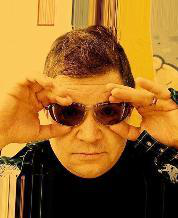

In [ ]:
PILImage.create(files[0])

## Fréchet Inception Distance (FID) 

The original implementation of the FID used the tensorflow weights of the [inceptionv3 from 2015-12-05](https://github.com/bioinf-jku/TTUR/blob/8eca1abd808aba8d8cf90208887453744bb53190/fid.py#L263), As noted by [hukkelas](https://github.com/hukkelas/pytorch-frechet-inception-distance).

In this implementation we use the pytorch/vision:v0.6.0 weights that produce much smaller outputs. This translates into much smaller values of FID. Nevertheless, the trend is present.

In [ ]:
#export
class Identity(nn.Module):
    '''An identity layer useful to shortcircuit the last layers of the inception network.'''
    def __init__(self): super(Identity, self).__init__()
    def forward(self, x): return x

In [ ]:
#export
class Inception(nn.Module):
    def __init__(self): 
        super().__init__()
        model = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
        model.eval();
        model.fc = Identity()
        model.dropout = Identity()
        self.model = model
    def __call__(self, x):
        x = Resize(299)(x)
        with torch.no_grad():
            return self.model(x)

In [ ]:
#export
class FIDMetric(GenMetric):
    def __init__(self, model, dl, get_prediction=noop):
        self.get_prediction = get_prediction
        self.func = model
        if dl.device.type == 'cuda':
            self.func.cuda()
        total = []
        for b in progress_bar(dl):
            if isinstance(b, tuple):
                if len(b)==2:
                    b = self.get_prediction(b[1])
            total.append(self.func(b))
        total = torch.cat(total).cpu()
        self.dist_norm = total.mean(axis=0).pow(2).sum().sqrt()
        #total = total / self.dist_norm
        self.dist_mean = total.mean(axis=0)
        self.dist_cov = (total-self.dist_mean).T@(total-self.dist_mean)/total.shape[0]
    def reset(self): self.total, self.count = [], 0
    def accumulate(self, learn):
        if learn.model.gen_mode:
            pred = self.get_prediction(learn.pred)
            self.total.append(learn.to_detach(self.func(pred)))
            self.count += 1
    
    @property
    def value(self): 
        if self.count == 0: return None
        total = torch.cat(self.total).cpu()#/self.dist_norm
        self.sample_mean = total.mean(axis=0).cpu()
        self.sample_cov = (total-self.sample_mean).T@(total-self.sample_mean)/total.shape[0]
        self.sample_cov = self.sample_cov.cpu()
        mean_loss = nn.MSELoss(reduction='sum')(self.sample_mean, self.dist_mean)
        cov_sqrt = linalg.sqrtm(self.sample_cov@self.dist_cov)
        if np.iscomplexobj(cov_sqrt):
            if not np.allclose(np.diagonal(cov_sqrt).imag, 0, atol=1e-3):
                m = np.max(np.abs(cov_sqrt.imag))
                raise ValueError("Imaginary component {}".format(m))
            cov_sqrt = cov_sqrt.real
        tcov1 = np.trace(self.sample_cov)
        tcov2 = np.trace(self.dist_cov)
        tcov_sqrt = np.trace(cov_sqrt)
        cov_loss = tcov1+tcov2-2*tcov_sqrt#np.trace(cov_sum - 2 * cov_sqrt)
        return mean_loss + cov_loss
    
    @property
    def name(self): return 'FID'

In [ ]:
tfdl = TfmdLists(files[:10000], [PILImage.create, ToTensor])
dl = tfdl.dataloaders(after_batch=[Resize(299, method=ResizeMethod.Squish),
                                   IntToFloatTensor(),
                                   Normalize.from_stats(*imagenet_stats)])


inception = Inception()
fid = FIDMetric(inception, dl.train)

Using cache found in /home/andres/.cache/torch/hub/pytorch_vision_v0.6.0


In [ ]:
class GaussianNoise(DisplayedTransform):
    order = 11
    def __init__(self, alpha):
        self.alpha = alpha
    def encodes(self, x:(Image.Image, TensorImage)): 
        N = torch.randn(x.shape, device=x.device)
        N -= N.min()
        N /= N.max()
        return (1-self.alpha)*x+self.alpha*N
    def decodes(self, x):
        return x

In [ ]:
imgs = []
fids = []
noise_levels = [0, 0.25, 0.5, 0.75]
for noise in master_bar(noise_levels):
    tfdl = TfmdLists(files[:10000], [PILImage.create, ToTensor])
    dl = tfdl.dataloaders(after_batch=[Resize(299, method=ResizeMethod.Squish),
                                       IntToFloatTensor(),
                                       GaussianNoise(noise),
                                       Normalize.from_stats(*imagenet_stats)],
                         shuffle_train=False)
    fid.reset()
    for b in progress_bar(dl.train):
        fid.total.append(fid.func(b))
    fid.count = len(dl.train)
    fids.append(fid.value)
    imgs.append(TensorImage(dl.decode(dl.one_batch())[0]))

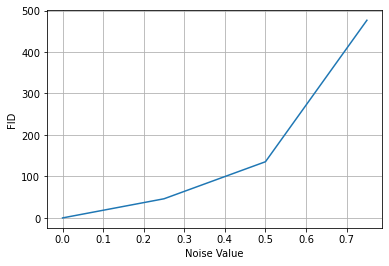

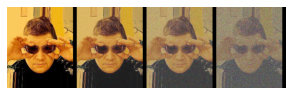

In [ ]:
plt.plot(noise_levels, fids)
plt.xlabel('Noise Value')
plt.ylabel('FID')
plt.grid(True)
ImageNTuple(imgs).show();

In [ ]:
class Blur(DisplayedTransform):
    order = 11
    def __init__(self, alpha):
        self.alpha = max(alpha, 1)
        padding = (self.alpha-1)//2
        self.conv = torch.nn.Conv2d(3, 3, self.alpha, groups=3, bias=False, padding=padding).cuda()
        torch.nn.init.constant_(self.conv.weight, 1/self.alpha**2)

    def encodes(self, x:(Image.Image, TensorImage)): return self.conv(x)

In [ ]:
imgs = []
fids = []
noise_levels = [0, 3, 5, 9]
for noise in master_bar(noise_levels):
    tfdl = TfmdLists(files[:50000], [PILImage.create, ToTensor])
    dl = tfdl.dataloaders(after_batch=[Resize(299, method=ResizeMethod.Squish),
                                       IntToFloatTensor(),
                                       Blur(noise),
                                       Normalize.from_stats(*imagenet_stats)],
                         shuffle_train=False)
    fid.reset()
    for b in progress_bar(dl.train):
        fid.total.append(fid.func(b))
    fid.count = len(dl.train)
    fids.append(fid.value)
    imgs.append(TensorImage(dl.decode(dl.one_batch())[0]))

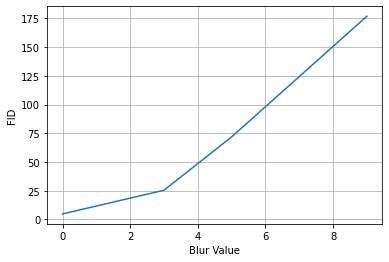

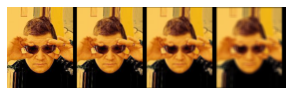

In [ ]:
plt.plot(noise_levels, fids)
plt.xlabel('Blur Value')
plt.ylabel('FID')
plt.grid(True)
ImageNTuple(imgs).show();

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_isola2017image.ipynb.
Converted 02_heusel2017gans.ipynb.
Converted index.ipynb.
